In [1]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.nonlinear_stokes.nonlinear_stokes_common import (
    plot_solution,
    loss_fn,
    fenics_to_jax,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
)

from src.nonlinear_stokes.nonlinear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

In [2]:
args = parser.parse_args("")
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

In [3]:
params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

/usr/local/anaconda3/envs/dvvf/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3000.803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [4]:
u_p = solve_fenics(params)

In [5]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

In [6]:
jax_fn = fenics_to_jax(u_p)

taylor = SecondOrderTaylorLookup(u_p, all_points)

In [7]:
defined_walls = np.array([x for x in points_on_walls if is_defined(x, u_p)])
defined_holes = np.array([x for x in points_on_holes if is_defined(x, u_p)])

u_p.set_allow_extrapolation(True)
u_inlet = np.array([u_p(x) for x in points_on_inlet])
u_walls = np.array([u_p(x) for x in points_on_walls])
u_holes = np.array([u_p(x) for x in points_on_holes])
u_domain = np.array([u_p(x) for x in points_in_domain])
u_p.set_allow_extrapolation(False)

u_defined_walls = np.array([u_p(x) for x in defined_walls])
u_defined_holes = np.array([u_p(x) for x in defined_holes])

In [8]:
def plot_mesh(u_p):
    fa.plot(
        u_p.function_space().mesh(),
        alpha=0.1
    )

def measure_fn_error(approx_fn, points, true_vals):
    error = np.linalg.norm(approx_fn(points) - true_vals, axis=1)
    rel_error = error / np.linalg.norm(true_vals, axis=1)
    print("mean abs err: ", np.mean(error))
    print("mean rel err: ", np.mean(rel_error))

    plt.figure(figsize=(4, 4))
    plt.title("Abs error distribution")
    plt.plot(np.arange(len(error))/len(error), np.sort(error))

    plt.figure(figsize=(4, 4))
    plt.title("Rel error distribution")
    plt.plot(np.arange(len(error))/len(error), np.sort(rel_error))

    plt.figure(figsize=(4, 4))
    plt.title("abs err")
    plot_mesh(u_p)
    clrs = plt.scatter(points[:, 0], points[:, 1], c=error)
    plt.colorbar(clrs)

    plt.figure(figsize=(4, 4))
    plt.title("rel err")
    plot_mesh(u_p)
    clrs = plt.scatter(points[:, 0], points[:, 1], c=rel_error)
    plt.colorbar(clrs)

    plt.show()

# jax_to_fenics (nearest neighbor interpolation)

mean abs err:  64.28142
mean rel err:  0.00468478561661196


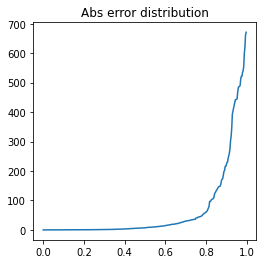

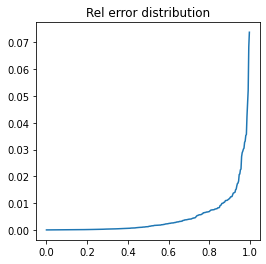

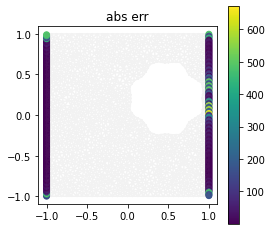

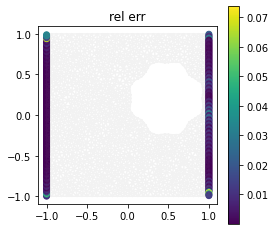

In [9]:
measure_fn_error(jax_fn, points_on_inlet, u_inlet)

mean abs err:  11.240757
mean rel err:  0.0080251949532626


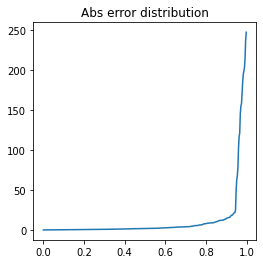

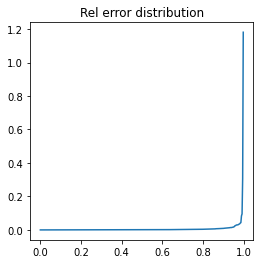

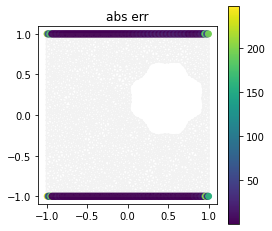

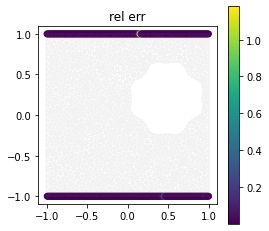

In [10]:
measure_fn_error(jax_fn, points_on_walls, u_walls)

mean abs err:  168.71245
mean rel err:  0.07591667153595488


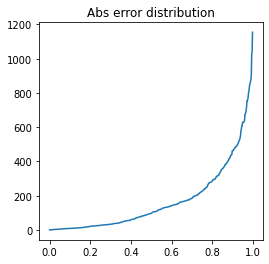

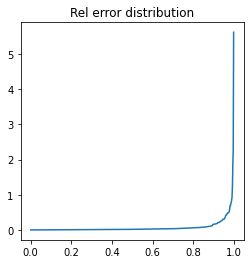

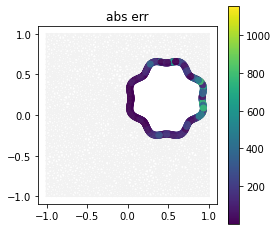

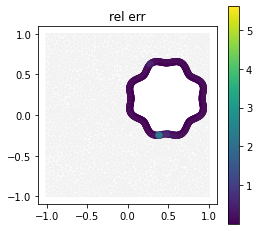

In [11]:
measure_fn_error(jax_fn, points_on_holes, u_holes)

mean abs err:  28.223383
mean rel err:  0.006119386844493289


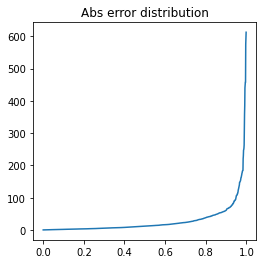

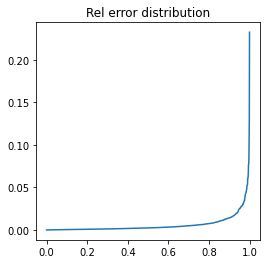

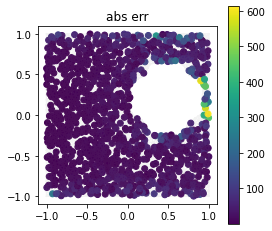

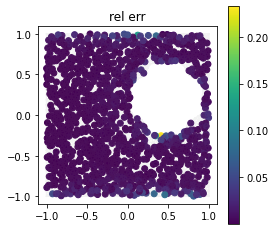

In [12]:
measure_fn_error(jax_fn, points_in_domain, u_domain)

mean abs err:  11.240757
mean rel err:  0.0080251949532626


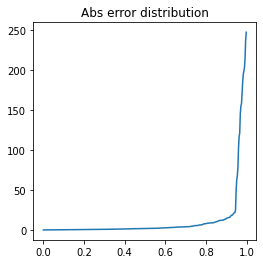

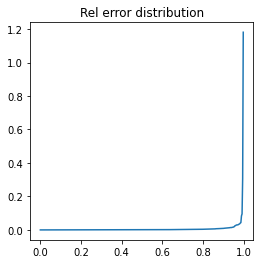

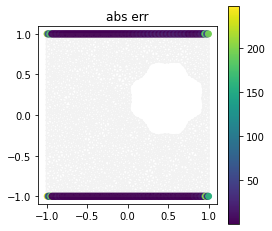

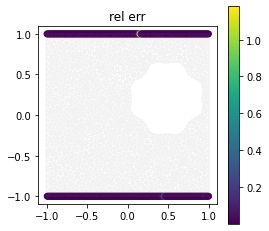

In [13]:
measure_fn_error(jax_fn, defined_walls, u_defined_walls)

mean abs err:  187.64188
mean rel err:  0.07008150222482505


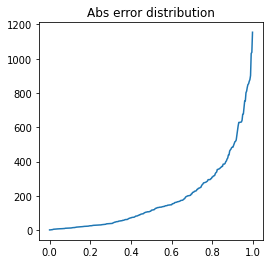

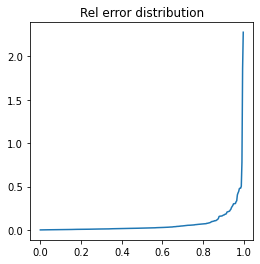

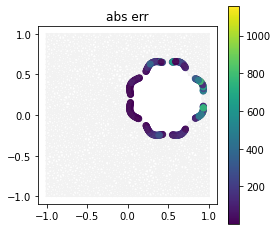

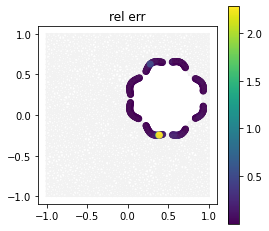

In [14]:
measure_fn_error(jax_fn, defined_holes, u_defined_holes)

# taylor expansion

mean abs err:  0.0
mean rel err:  0.0


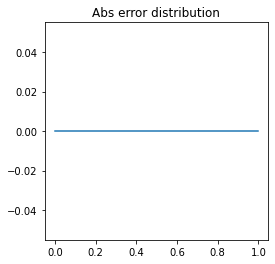

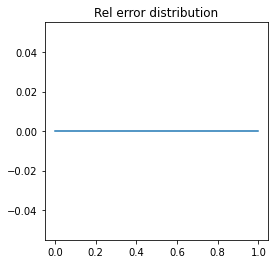

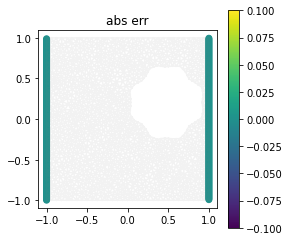

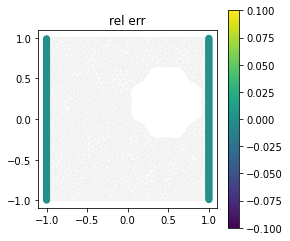

In [15]:
measure_fn_error(taylor, points_on_inlet, u_inlet)

mean abs err:  0.0
mean rel err:  0.0


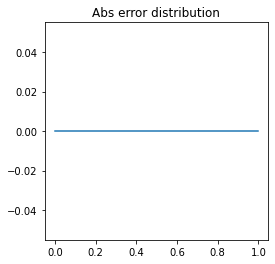

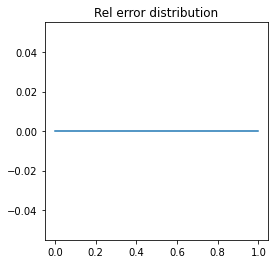

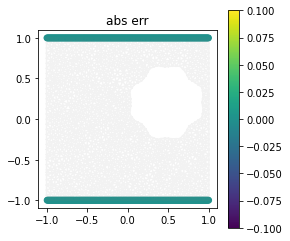

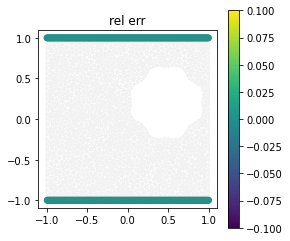

In [16]:
measure_fn_error(taylor, points_on_walls, u_walls)

mean abs err:  0.0
mean rel err:  0.0


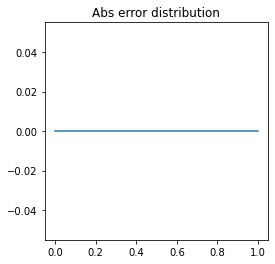

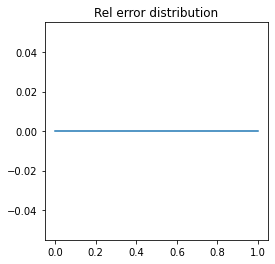

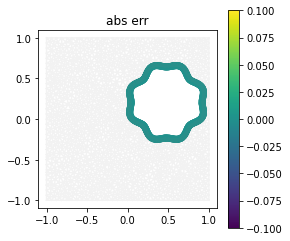

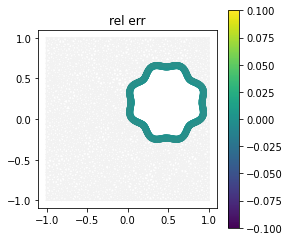

In [17]:
measure_fn_error(taylor, points_on_holes, u_holes)

mean abs err:  0.0
mean rel err:  0.0


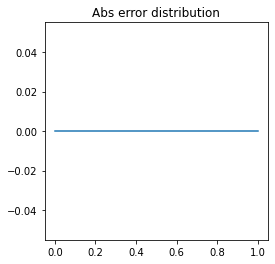

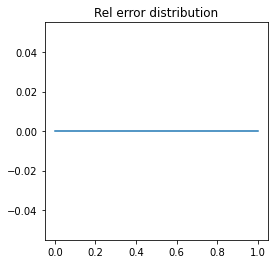

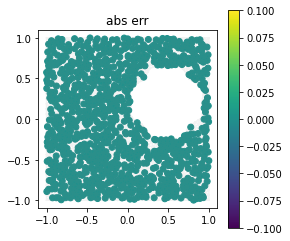

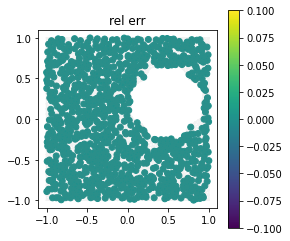

In [18]:
measure_fn_error(taylor, points_in_domain, u_domain)

mean abs err:  0.0
mean rel err:  0.0


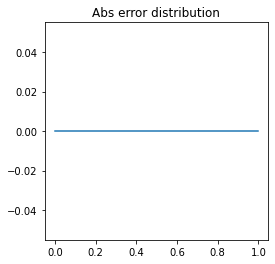

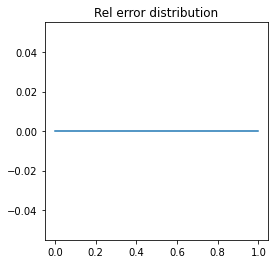

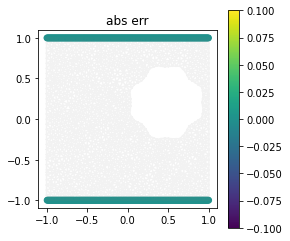

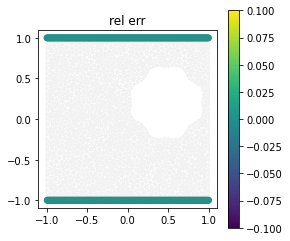

In [19]:
measure_fn_error(taylor, defined_walls, u_defined_walls)

mean abs err:  0.0
mean rel err:  0.0


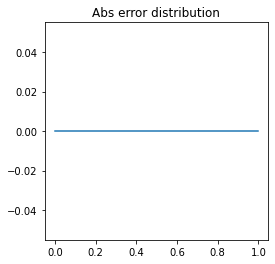

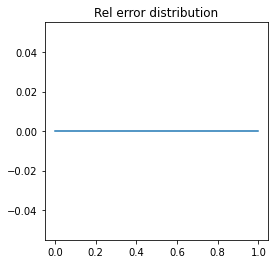

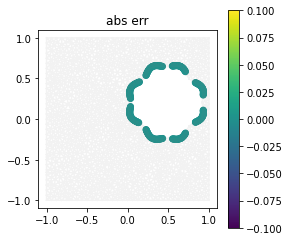

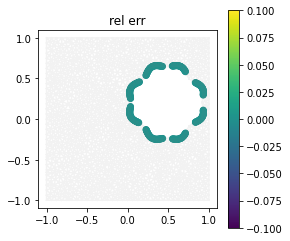

In [20]:
measure_fn_error(taylor, defined_holes, u_defined_holes)

# Investigating the loss function using Taylor


In [21]:
from src.nonlinear_stokes.nonlinear_stokes_common import (
    loss_domain_fn,
    loss_inlet_fn,
    loss_noslip_fn
)

points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
all_points = np.concatenate(points)
coords = np.array(u_p.function_space().tabulate_dof_coordinates())

In [22]:
loss_fn(taylor, (points_on_inlet, points_on_walls, 
                 points_on_holes, points_in_domain),
        params)

({'loss_noslip': DeviceArray(234553.42, dtype=float32),
  'loss_inlet': DeviceArray(1.3386457e-23, dtype=float32)},
 {'loss_in_domain': DeviceArray(38860936., dtype=float32),
  'mean_square_pressure': DeviceArray(3379.7046, dtype=float32)})

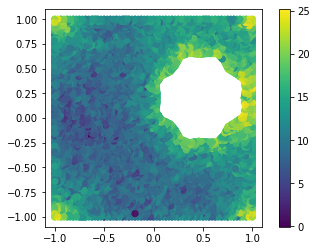

In [23]:
# Domain loss (which isn't enforced on boundaries)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                taylor, coords, params),
        axis=1)))
plt.colorbar(clrs)

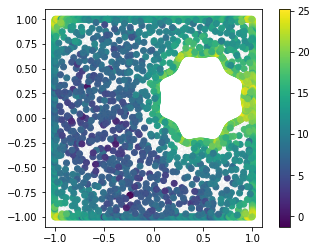

In [24]:
# Domain loss (which isn't enforced on boundaries)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                taylor, all_points, params),
        axis=1)))
plt.colorbar(clrs)

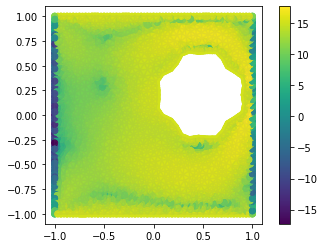

In [25]:
# Inlet loss (which is only enforced on inlet)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                taylor, coords, params),
        axis=1)))
plt.colorbar(clrs)

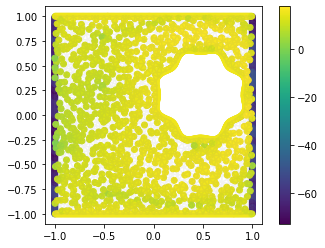

In [26]:
# Inlet loss (which is only enforced on inlet)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                taylor, all_points, params),
        axis=1)))
plt.colorbar(clrs)

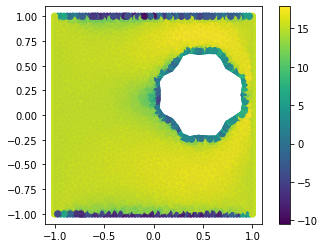

In [27]:
# Noslip loss (which is only enforced on walls/hole)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                taylor, coords, params),
        axis=1)))
plt.colorbar(clrs)

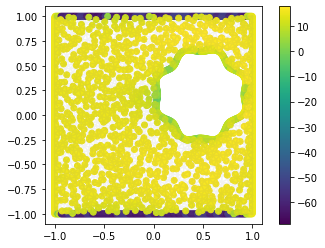

In [28]:
# Noslip loss (which is only enforced on walls/hole)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                taylor, all_points, params),
        axis=1)))
plt.colorbar(clrs)

# Investigate the loss fn using fenics_to_jax interpolation

In [29]:
loss_fn(jax_fn, (points_on_inlet, points_on_walls, 
                 points_on_holes, points_in_domain),
        params)

({'loss_noslip': DeviceArray(248942.38, dtype=float32),
  'loss_inlet': DeviceArray(1.2796636e-23, dtype=float32)},
 {'loss_in_domain': DeviceArray(nan, dtype=float32),
  'mean_square_pressure': DeviceArray(3463.8909, dtype=float32)})

In [ ]:
# Domain loss (which isn't enforced on boundaries)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                jax_fn, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Domain loss (which isn't enforced on boundaries)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                jax_fn, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Inlet loss (which is only enforced on inlet)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                jax_fn, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Inlet loss (which is only enforced on inlet)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                jax_fn, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Noslip loss (which is only enforced on walls/hole)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                jax_fn, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Noslip loss (which is only enforced on walls/hole)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                jax_fn, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
plot_mesh(u_p)
clrs = plt.scatter(
    points_on_holes[:, 0], points_on_holes[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                jax_fn, points_on_holes, params),
        axis=1)))
plt.colorbar(clrs)